In [1]:
using GLM
using CSV
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [2]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.785212889969301

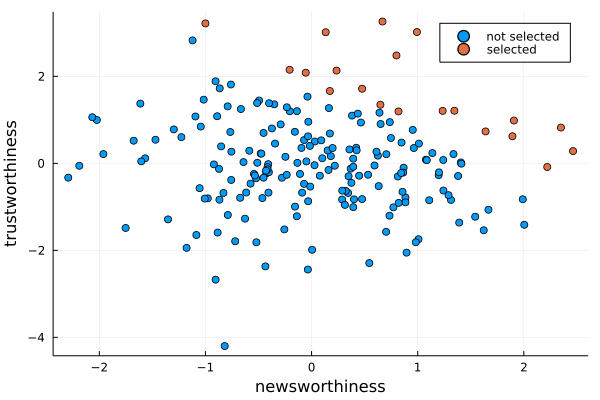

In [3]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [4]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

Code 6.3

In [5]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%     histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ 0.6542  0.3289   0.1355  0.6403  1.1769  ▁▁▃▅██▆▄▂▁▁▁ │
│    bl │   1.96  2.0095  -1.0311  1.8645  5.2231     ▁▁▁▄██▃▁▁ │
│    br │ 0.1123  2.0152  -3.2163  0.1895  3.1701     ▁▁▃██▄▁▁▁ │
│     σ │ 0.6153  0.0473   0.5396  0.6128  0.6969       ▁▂▆█▄▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 6.4

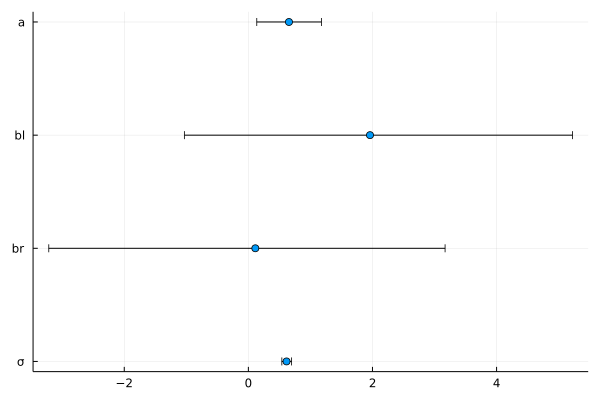

In [6]:
coeftab_plot(m6_1_df)

Code 6.5

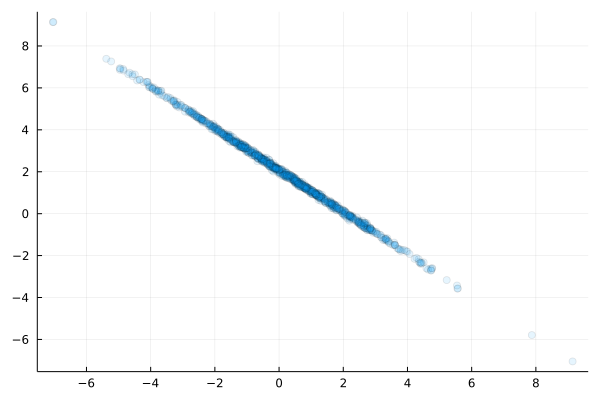

In [7]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1)

Code 6.6

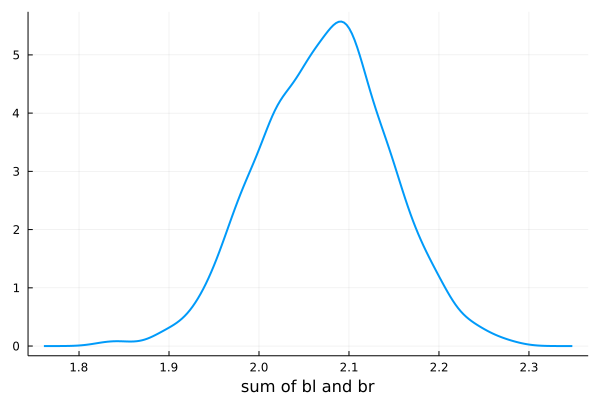

In [8]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

Code 6.7

In [9]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%     histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 0.6476  0.3469  0.1062  0.6417  1.2179  ▁▁▁▄▆██▇▄▂▁▁ │
│    bl │ 2.0749  0.0757  1.9504  2.0761  2.1935     ▁▂▄▇█▇▅▂▁ │
│     σ │ 0.6094   0.043  0.5441  0.6059  0.6838       ▁▂██▃▁▁ │
└───────┴──────────────────────────────────────────────────────┘


In [10]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(2.009472275684534, 2.0151867708503977, 0.07155679095718502)

Code 6.8

In [11]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

Code 6.9

In [12]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)

precis(m6_3_df)
precis(m6_4_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%       histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 0.0002   0.088  -0.1375  0.0015  0.1355        ▁▁▃██▃▁▁ │
│    bF │ 0.8553  0.0925   0.7029  0.8543  1.0037  ▁▁▁▂▃▅██▇▄▂▁▁▁ │
│     σ │  0.489  0.0742     0.39   0.479   0.619     ▁▃▇█▆▃▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘
┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ -0.0005  0.0753  -0.1181  -0.0011  0.1165   ▁▁▃▆██▆▃▁▁ │
│    bL │ -0.9015  0.0757  -1.0273   -0.903  -0.777  ▁▁▂▅██▄▂▁▁▁ │
│     σ │  0.4124  0.0555   0.3336   0.4072  0.5068     ▁▃██▄▂▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.10

In [13]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)
precis(m6_5_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │ -0.0043  0.0711   -0.114  -0.0066   0.1084      ▁▁▂▆██▅▂▁▁ │
│    bF │  0.2225  0.1858  -0.0743   0.2246   0.5241  ▁▁▁▂▃▅▇█▆▄▂▁▁▁ │
│    bL │ -0.6972  0.1837  -1.0002  -0.6913  -0.4105        ▁▁▄█▄▁▁▁ │
│     σ │  0.4158  0.0638   0.3302   0.4067   0.5354       ▁▃█▇▄▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 6.11

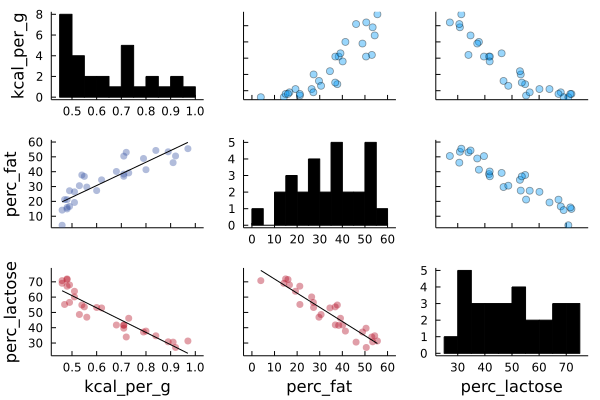

In [14]:
@df d corrplot([:kcal_per_g :perc_fat :perc_lactose]; seriestype=:scatter, bins=10, grid=false)

Code 6.12

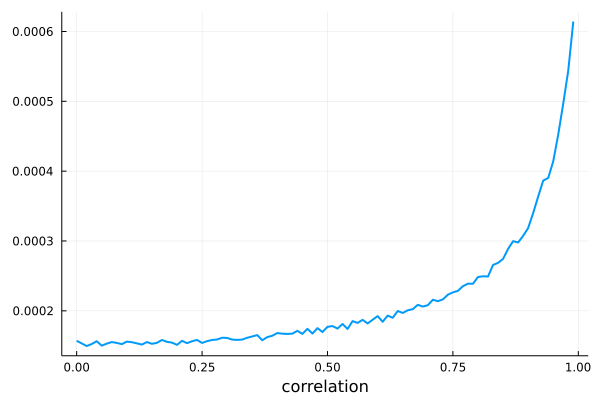

In [15]:
# get mean stderr for linear model's scale
function stderr_for_r(r)
    σ = sqrt(1-r^2)*var(d.perc_fat)
    fat_scaled = r .* d.perc_fat
    stderr_x = [
        begin
            x = d.perc_fat .+ rand(MvNormal(fat_scaled, σ))
            # add the intercept to the model
            X = hcat(ones(length(x)), x)
            m = lm(X, d.kcal_per_g)
            stderror(m)[2]
        end
        for _ in 1:100
    ]
    s = mean(stderr_x)
end

r_seq = range(0, 0.99; step=0.01)
s = stderr_for_r.(r_seq)
plot(r_seq, s; lw=2, xlab="correlation")

# 6.2 Post-treatment bias

Code 6.13

In [16]:
Random.seed!(70)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d)

┌───────────┬───────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%     50%    94.5%       histogram │
├───────────┼───────────────────────────────────────────────────────────┤
│        h0 │  9.9795   1.915    7.281  9.7521  13.2437     ▁▂▃▅█▆▃▃▂▁▁ │
│        h1 │ 14.0642   2.561  10.2762  13.961  17.7881  ▁▁▂▃▄█▅▆▃▅▅▁▁▁ │
│ treatment │     0.5  0.5025      0.0     0.5      1.0     █▁▁▁▁▁▁▁▁▁█ │
│    fungus │    0.32  0.4688      0.0     0.0      1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴───────────────────────────────────────────────────────────┘


Code 6.14

In [17]:
sim_p = rand(LogNormal(0, 0.25), 10_000)
precis(DataFrame(:sim_p => sim_p))

┌───────┬───────────────────────────────────────────────────┐
│ param │   mean    std    5.5%     50%   94.5%   histogram │
├───────┼───────────────────────────────────────────────────┤
│ sim_p │ 1.0377  0.265  0.6718  1.0041  1.4985  ▁▄█▇▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────┘


Code 6.15

In [18]:
@model function model_m6_6(h0, h1)
    p ~ LogNormal(0, 0.25)
    σ ~ Exponential(1)
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_6 = sample(model_m6_6(d.h0, d.h1), NUTS(), 1000)
m6_6_df = DataFrame(m6_6)
precis(m6_6_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     p │ 1.3946  0.0189  1.3658  1.3942  1.4257  ▁▁▁▁▃▆▇██▅▃▁▁▁ │
│     σ │ 1.8391  0.1309  1.6332  1.8342  2.0564        ▁▃██▅▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.16

In [19]:
@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)
precis(m6_7_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  1.4828  0.0209   1.4509   1.4828   1.5179       ▁▁▃▇█▄▁▁ │
│    bf │ -0.2794  0.0263  -0.3201  -0.2797  -0.2368     ▁▁▂▅██▅▂▁▁ │
│    bt │  0.0138  0.0246  -0.0249   0.0139   0.0535     ▁▁▂▆█▇▃▁▁▁ │
│     σ │  1.2121  0.0903   1.0733   1.2056   1.3646  ▁▁▄▇██▇▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 6.17

In [20]:
@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
m6_8_df = DataFrame(m6_8)
precis(m6_8_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%      histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ 1.3326   0.023   1.296   1.333  1.3691       ▁▂▆█▇▃▁▁ │
│    bt │ 0.1234  0.0334  0.0695  0.1233  0.1768  ▁▁▁▁▂▄▇█▆▃▁▁▁ │
│     σ │ 1.7346  0.1295  1.5424  1.7244  1.9543     ▁▁▃██▅▂▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 6.18

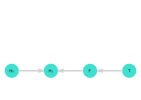

In [21]:
plant_dag = Dagitty.DAG(:H₀ => :H₁, :F => :H₁, :T => :F)
drawdag(plant_dag, [2, 0, 1, 3], [0, 0, 0, 0])

Code 6.19

In [22]:
implied_conditional_independencies_min(plant_dag)

3-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:F, :H₀, Symbol[])
 ConditionalIndependence(:H₀, :T, Symbol[])
 ConditionalIndependence(:H₁, :T, [:F])

Code 6.20

In [23]:
Random.seed!(70)
# number of plants
N = 1000
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
M = rand(Bernoulli(), N)
fungus = [
    rand(Binomial(1, 0.5 - treat*0.4 + 0.4 * m)) 
    for (treat, m) ∈ zip(treatment, M)
]
h1 = h0 .+ rand(MvNormal(5 .+ 3 .* M, 1))

d2 = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d2)

┌───────────┬────────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%      50%    94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────────┤
│        h0 │ 10.0411  2.0531   6.7597   9.9194  13.2845  ▁▁▁▂▄▆█▇▆▄▂▁▁▁ │
│        h1 │ 16.5145  2.8202  12.0612  16.5204  21.1399       ▁▂▅▇█▆▃▁▁ │
│ treatment │     0.5  0.5003      0.0      0.5      1.0     █▁▁▁▁▁▁▁▁▁█ │
│    fungus │   0.511  0.5001      0.0      1.0      1.0     █▁▁▁▁▁▁▁▁▁█ │
└───────────┴────────────────────────────────────────────────────────────┘


In [24]:
m6_7 = sample(model_m6_7(d2.h0, d2.treatment, d2.fungus, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_7))

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%    histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 1.5187  0.0146  1.4941  1.5192  1.5407   ▁▂▃▆██▅▂▁▁ │
│    bf │ 0.1348  0.0145  0.1124  0.1339  0.1589  ▁▁▁▄▅█▅▃▂▁▁ │
│    bt │  0.063  0.0143  0.0403  0.0627   0.086   ▁▁▂▅██▆▃▂▁ │
│     σ │ 2.0876  0.0452  2.0171  2.0878  2.1573      ▁▁▄█▇▂▁ │
└───────┴─────────────────────────────────────────────────────┘


In [25]:
m6_8 = sample(model_m6_8(d2.h0, d2.treatment, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_8))

┌───────┬────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%  histogram │
├───────┼────────────────────────────────────────────────────┤
│     a │  1.618  0.0095   1.6025  1.6182  1.6328  ▁▁▄██▂▁▁▁ │
│    bt │ 0.0054  0.0129  -0.0155  0.0055   0.026  ▁▁▃▆█▇▃▁▁ │
│     σ │ 2.1759  0.0487   2.0951  2.1758  2.2525   ▁▂▅█▅▂▁▁ │
└───────┴────────────────────────────────────────────────────┘


# 6.3 Collider bias

Code 6.21

In [26]:
d = sim_happiness(seed=1977, n_years=1000)
precis(d)

┌───────────┬────────────────────────────────────────────────────────┐
│     param │   mean      std     5.5%   50%   94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────┤
│       age │   33.0  18.7689      4.0  33.0    62.0  ▇████████████▂ │
│ happiness │   -0.0   1.2144  -1.7895   0.0  1.7895       █▆█▆▆█▆▆▃ │
│   married │ 0.2954   0.4564      0.0   0.0     1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴────────────────────────────────────────────────────────┘


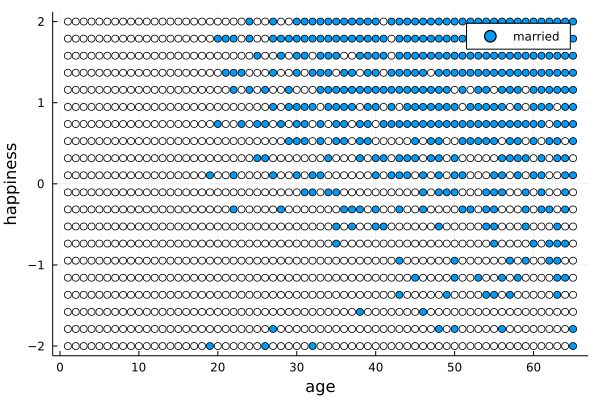

In [27]:
d_m = d[d.married .== 1,[:age,:happiness]]
d_u = d[d.married .== 0,[:age,:happiness]]

scatter(d_m.age, d_m.happiness; label="married", xlab="age", ylab="happiness")
scatter!(d_u.age, d_u.happiness; c=:white)

Code 6.22

In [28]:
d2 = d[d.age .> 17,:]
d2[!,:A] = @. (d2.age - 18) / (65-18);

Code 6.23

In [29]:
d2[!,:mid] = d2.married .+ 1;

In [30]:
@model function model_m6_9(mid, A, happiness)
    a ~ MvNormal([0, 0], 1)
    bA ~ Normal(0, 2)
    μ = a[mid] .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_9 = sample(model_m6_9(d2.mid, d2.A, d2.happiness), NUTS(), 1000)
m6_9_df = DataFrame(m6_9)
precis(m6_9_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │ -0.2233  0.0691  -0.3341  -0.2221  -0.1151    ▁▁▃▆█▇▃▁▁▁ │
│  a[2] │  1.2335  0.0912   1.0882   1.2301   1.3791  ▁▁▂▄▇█▇▅▃▁▁▁ │
│    bA │ -0.7222  0.1221  -0.9171  -0.7239  -0.5291     ▁▁▂▅█▇▃▁▁ │
│     σ │   1.007  0.0225   0.9736   1.0062   1.0451     ▁▁▃▇█▅▂▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 6.24

In [31]:
@model function model_m6_10(A, happiness)
    a ~ Normal()
    bA ~ Normal(0, 2)
    μ = a .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_10 = sample(model_m6_10(d2.A, d2.happiness), NUTS(), 1000)
m6_10_df = DataFrame(m6_10)
precis(m6_10_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │  0.0037  0.0772  -0.1216   0.0046  0.1228  ▁▁▃▅▇█▆▃▁▁▁ │
│    bA │ -0.0061  0.1342  -0.2168  -0.0103   0.215    ▁▁▂▆██▅▂▁ │
│     σ │   1.217  0.0292   1.1717   1.2164   1.265  ▁▁▃▇██▄▃▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.25

In [32]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2;

Code 6.26

In [33]:
Random.seed!(6)
U = 2 .* rand(Bernoulli(), N) .- 1
G = rand(Normal(), N)
P = rand(MvNormal(@. b_GP*G + b_U*U))
C = rand(MvNormal(@. b_PC*P + b_GC*G + b_U*U))
d = DataFrame(:C => C, :P => P, :G => G, :U => U);

Code 6.27

In [34]:
@model function model_m6_11(P, G, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    μ = @. a + b_PC*P + b_GC*G
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_11 = sample(model_m6_11(d.P, d.G, d.C), NUTS(), 1000)
m6_11_df = DataFrame(m6_11)
precis(m6_11_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.0767  0.2333  -0.2978   0.0776  0.4421      ▁▁▁▂▇█▅▂▁▁ │
│  b_GC │ -0.0237  0.2027  -0.3552  -0.0257  0.3005        ▁▁▄██▄▁▁ │
│  b_PC │   0.219  0.1041   0.0464   0.2196  0.3837  ▁▁▁▂▃████▇▃▂▁▁ │
│     σ │  3.3784  0.1664   3.1256   3.3733  3.6578     ▁▂▄▇██▅▂▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 6.28

In [35]:
@model function model_m6_12(P, G, U, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    b_U ~ Normal()
    μ = @. a + b_PC*P + b_GC*G + b_U*U
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_12 = sample(model_m6_12(d.P, d.G, d.U, d.C), NUTS(), 1000)
m6_12_df = DataFrame(m6_12)
precis(m6_12_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.0909  0.2293  -0.2915   0.0859  0.4679       ▁▁▂▆█▅▂▁▁ │
│  b_GC │ -0.0339  0.2202  -0.3697    -0.04  0.3041        ▁▂▅██▃▁▁ │
│  b_PC │  0.2175   0.104   0.0533    0.218  0.3866  ▁▁▁▂▄▅██▇▄▄▁▁▁ │
│   b_U │ -0.1095  0.2438  -0.5261  -0.1094  0.2809       ▁▁▃▇█▆▃▁▁ │
│     σ │   3.385  0.1651   3.1278   3.3803  3.6627    ▁▁▂▄▇██▆▃▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


# 6.4 Confronting confounding

Code 6.29

In [36]:
dag_61 = Dagitty.DAG(
    :X => :Y,
    :U => :X, :A => :U,
    :A => :C, :C => :Y,
    :U => :B, :C => :B,
)

all_backdoor_adjustment_sets(dag_61, :X, :Y)

3-element Vector{Vector{Symbol}}:
 [:A]
 [:C]
 [:U]

Code 6.30

In [37]:
dag_62 = Dagitty.DAG(
    :A => :D,
    :A => :M, :M => :D,
    :S => :A, :S => :M,
    :S => :W, :W => :D,
)
all_backdoor_adjustment_sets(dag_62, :W, :D)

2-element Vector{Vector{Symbol}}:
 [:S]
 [:A, :M]

In [38]:
implied_conditional_independencies_min(dag_62)

3-element Vector{ConditionalIndependence}:
 ConditionalIndependence(:A, :W, [:S])
 ConditionalIndependence(:D, :S, [:A, :M, :W])
 ConditionalIndependence(:M, :W, [:S])